In [ ]:

!pwd

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os

# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/MyDrive/"

# choose where you want your project files to be saved
project_folder = "Major Project"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  # !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)


Your working directory was changed to /content/drive/MyDrive/Major Project

An empty text file was created there. You can also run !pwd to confirm the current working directory.


In [ ]:
!pwd

/content/drive/MyDrive/Major Project


In [ ]:
os.environ['KAGGLE_USERNAME'] = "vedanthr" # username from the json file
os.environ['KAGGLE_KEY'] = "f54bc7643b23975c0ff08e4ba567f796" # key from the json file

In [ ]:
!kaggle datasets download -d vedanthr/distracted-driver-custom

100% 901M/905M [00:05<00:00, 170MB/s]
100% 905M/905M [00:05<00:00, 162MB/s]


In [ ]:
!unzip "/content/drive/MyDrive/Major Project/distracted-driver-custom.zip" -d "/content/drive/MyDrive/Major Project/distracted_drivers_dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Major Project/distracted_drivers_dataset/imgs/train/c7/img_24500.jpg  
  inflating: /content/drive/MyDrive/Major Project/distracted_drivers_dataset/imgs/train/c7/img_24520.jpg  
  inflating: /content/drive/MyDrive/Major Project/distracted_drivers_dataset/imgs/train/c7/img_24583.jpg  
  inflating: /content/drive/MyDrive/Major Project/distracted_drivers_dataset/imgs/train/c7/img_24598.jpg  
  inflating: /content/drive/MyDrive/Major Project/distracted_drivers_dataset/imgs/train/c7/img_24661.jpg  
  inflating: /content/drive/MyDrive/Major Project/distracted_drivers_dataset/imgs/train/c7/img_24670.jpg  
  inflating: /content/drive/MyDrive/Major Project/distracted_drivers_dataset/imgs/train/c7/img_24762.jpg  
  inflating: /content/drive/MyDrive/Major Project/distracted_drivers_dataset/imgs/train/c7/img_24866.jpg  
  inflating: /content/drive/MyDrive/Major Project/distracted_drivers_dataset/imgs/train/c7/im

In [ ]:
import tensorflow as tf

In [ ]:
av_model = tf.keras.model.load_model("augmented_vanilla_cnn.h5")

In [ ]:
import os
from glob import glob
import random
import time
import tensorflow
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR messages are not printed

from tqdm import tqdm

import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16

In [ ]:
import pandas as pd
dataset = pd.read_csv('/content/drive/MyDrive/Major Project/distracted_drivers_dataset/driver_imgs_list.csv')
dataset.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [ ]:
by_drivers = dataset.groupby('subject')
unique_drivers = by_drivers.groups.keys()
print(unique_drivers)

dict_keys(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081'])


In [ ]:
# Load the dataset previously downloaded from Kaggle
NUMBER_CLASSES = 10
# Color type: 1 - grey, 3 - rgb

In [ ]:
def get_cv2_image(path, img_rows, img_cols, color_type=3):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    # Reduce size
    img = cv2.resize(img, (img_rows, img_cols))
    return img

In [ ]:
# Training
# In mounted Google drive
# /content/drive/MyDrive/Major Project/distracted_drivers_dataset/imgs/train/c0
def load_train(img_rows, img_cols, color_type=3):
    start_time = time.time()
    train_images = []
    train_labels = []
    # Loop over the training folder
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('/content', 'drive', 'MyDrive', 'Major Project', 'distracted_drivers_dataset', 'imgs', 'train', 'c' + str(classed), '*.jpg'))
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
        print(len(files),"**")
    print("Data Loaded in {} second".format(time.time() - start_time))
    return train_images, train_labels

In [ ]:
print(os.path.join('content', 'drive', 'MyDrive', 'Major Project', 'distracted_drivers_dataset', 'imgs', 'train', 'c' + '0', '*.jpg'))

content/drive/MyDrive/Major Project/distracted_drivers_dataset/imgs/train/c0/*.jpg


In [ ]:
def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)

    return x_train, x_test, y_train, y_test

In [ ]:
# Testing
# In mounted Google drive
# /content/drive/MyDrive/Major Project/distracted_drivers_dataset/imgs/test/c0
def load_test(img_rows, img_cols, color_type=3):
    start_time = time.time()
    test_images = []
    test_labels = []
    # Loop over the testing folder
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('/content', 'drive', 'MyDrive', 'Major Project', 'distracted_drivers_dataset', 'imgs', 'test', 'c' + str(classed), '*.jpg'))
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            test_images.append(img)
            test_labels.append(classed)
        # print(len(files),"**")
    print("Data Loaded in {} second".format(time.time() - start_time))
    return test_images, test_labels


def read_and_normalize_test_data(img_rows, img_cols, color_type):
    X_test_new, labels = load_test(img_rows, img_cols, color_type)
    y_test_new = np_utils.to_categorical(labels, 10)
    X_test_new = np.array(X_test_new, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    return X_test_new, y_test_new

In [ ]:
img_rows = 64
img_cols = 64
color_type = 1

Should be 19924 train-validate images and 2500 test images

In [ ]:
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)
print('Train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [02:00<18:08, 120.98s/it]

2239 **
Loading directory c1


 20%|██        | 2/10 [03:03<11:33, 86.70s/it] 

2017 **
Loading directory c2


 30%|███       | 3/10 [04:21<09:37, 82.48s/it]

2067 **
Loading directory c3


 40%|████      | 4/10 [05:41<08:10, 81.76s/it]

2096 **
Loading directory c4


 50%|█████     | 5/10 [06:49<06:23, 76.74s/it]

2076 **
Loading directory c5


 60%|██████    | 6/10 [07:56<04:53, 73.32s/it]

2062 **
Loading directory c6


 70%|███████   | 7/10 [09:12<03:42, 74.13s/it]

2075 **
Loading directory c7


 80%|████████  | 8/10 [10:15<02:21, 70.74s/it]

1752 **
Loading directory c8


 90%|█████████ | 9/10 [11:05<01:04, 64.38s/it]

1661 **
Loading directory c9


100%|██████████| 10/10 [12:00<00:00, 72.04s/it]

1879 **
Data Loaded in 720.4573328495026 second
Train shape: (15939, 64, 64, 1)
15939 train samples


In [ ]:
x_test_new, y_test_new = read_and_normalize_test_data(img_rows, img_cols, color_type)
print('Test shape:', x_test_new.shape)
print(x_test_new.shape[0], 'test samples')

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:00<00:08,  1.02it/s]

Loading directory c1


 20%|██        | 2/10 [00:02<00:08,  1.01s/it]

Loading directory c2


 30%|███       | 3/10 [00:03<00:07,  1.02s/it]

Loading directory c3


 40%|████      | 4/10 [00:04<00:06,  1.01s/it]

Loading directory c4


 50%|█████     | 5/10 [00:05<00:05,  1.01s/it]

Loading directory c5


 60%|██████    | 6/10 [00:06<00:04,  1.01s/it]

Loading directory c6


 70%|███████   | 7/10 [00:07<00:03,  1.00s/it]

Loading directory c7


 80%|████████  | 8/10 [00:08<00:02,  1.00s/it]

Loading directory c8


 90%|█████████ | 9/10 [00:09<00:00,  1.00it/s]

Loading directory c9


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]

Data Loaded in 10.035929679870605 second
Test shape: (2500, 64, 64, 1)
2500 test samples


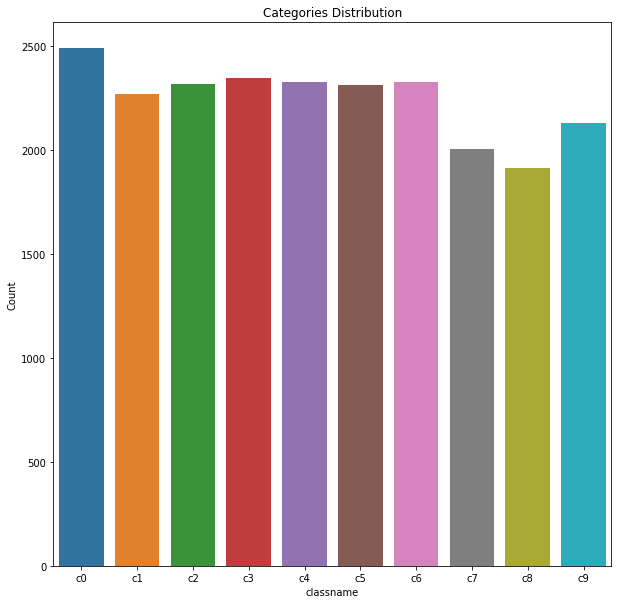

In [ ]:
# Plot figure size
plt.figure(figsize = (10,10))
# Count the number of images per category
sns.countplot(x = 'classname', data = dataset)
# Change the Axis names
plt.ylabel('Count')
plt.title('Categories Distribution')
# Show plot
plt.show()

In [ ]:
# Find the frequency of images per driver
drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
drivers_id

,driver_id,Counts
0,p021,1237
1,p022,1233
2,p024,1226
3,p026,1196
4,p016,1078
5,p066,1034
6,p049,1011
7,p051,920
8,p014,876
9,p015,875


<Figure size 1440x1440 with 0 Axes>

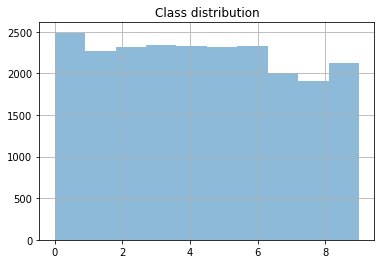

In [ ]:
# Plotting class distribution
dataset['class_type'] = dataset['classname'].str.extract('(\d)',expand=False).astype(np.float)
plt.figure(figsize = (20,20))
dataset.hist('class_type', alpha=0.5, layout=(1,1), bins=10)
plt.title('Class distribution')
plt.show()

In [ ]:
activity_map = {'c0': 'Safe driving',
                'c1': 'Texting - right',
                'c2': 'Talking on the phone - right',
                'c3': 'Texting - left',
                'c4': 'Talking on the phone - left',
                'c5': 'Operating the radio',
                'c6': 'Drinking',
                'c7': 'Reaching behind',
                'c8': 'Hair and makeup',
                'c9': 'Talking to passenger'}

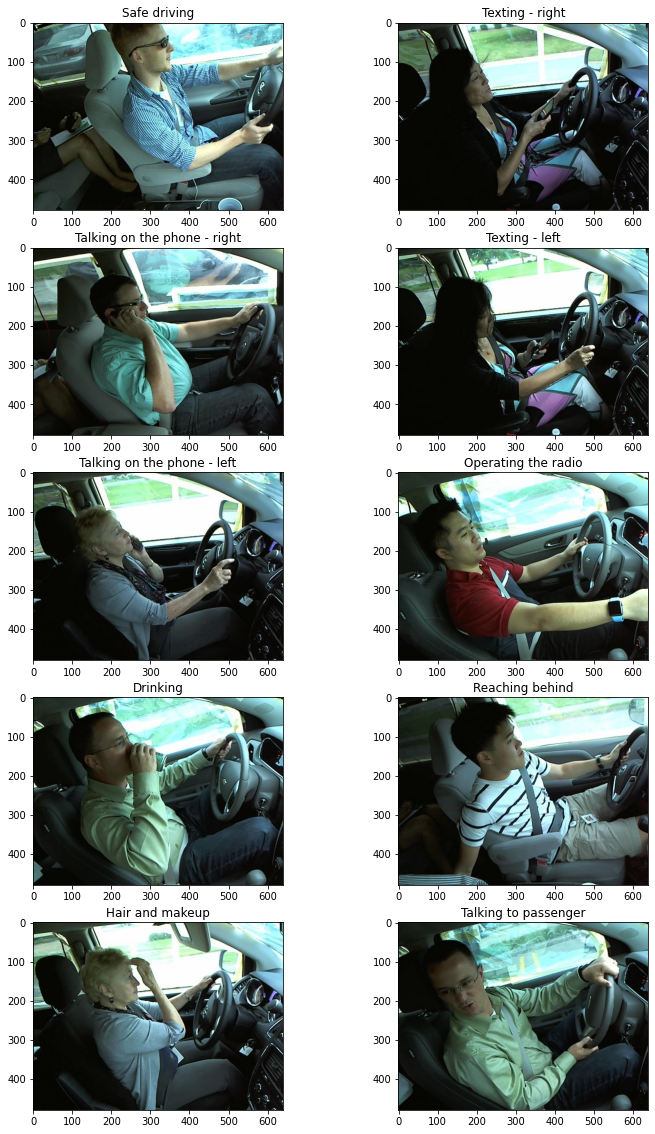

In [ ]:
plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = '/content/drive/MyDrive/Major Project/distracted_drivers_dataset/imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

In [ ]:
batch_size = 40
nb_epoch = 30

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights_best_vanilla.hdf5',
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
callbacks = [checkpointer, es]

**Optimised Vanilla CNN Model**

In [ ]:
def create_model_v2():
    # Optimised Vanilla CNN model
    model = Sequential()

    ## CNN 1
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 2
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 3
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.5))

    ## Output
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))

    return model

In [ ]:
model_v2 = create_model_v2()

# More details about the layers
model_v2.summary()

# Compiling the model
model_v2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 62, 62, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                        

In [ ]:
history_v2 = model_v2.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          callbacks=callbacks,
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

Epoch 1/10
399/399 [==============================] - ETA: 0s - loss: 1.2778 - accuracy: 0.5782
Epoch 1: val_loss improved from inf to 0.76667, saving model to saved_models/weights_best_vanilla.hdf5
399/399 [==============================] - 21s 26ms/step - loss: 1.2778 - accuracy: 0.5782 - val_loss: 0.7667 - val_accuracy: 0.8085
Epoch 2/10
397/399 [============================>.] - ETA: 0s - loss: 0.3756 - accuracy: 0.8782
Epoch 2: val_loss improved from 0.76667 to 0.29205, saving model to saved_models/weights_best_vanilla.hdf5
399/399 [==============================] - 10s 25ms/step - loss: 0.3763 - accuracy: 0.8783 - val_loss: 0.2920 - val_accuracy: 0.9207
Epoch 3/10
397/399 [============================>.] - ETA: 0s - loss: 0.2223 - accuracy: 0.9310
Epoch 3: val_loss improved from 0.29205 to 0.14862, saving model to saved_models/weights_best_vanilla.hdf5
399/399 [==============================] - 10s 24ms/step - loss: 0.2221 - accuracy: 0.9310 - val_loss: 0.1486 - val_accuracy: 0.9

In [ ]:
def plot_train_history(history):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

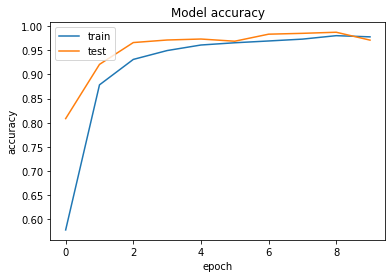

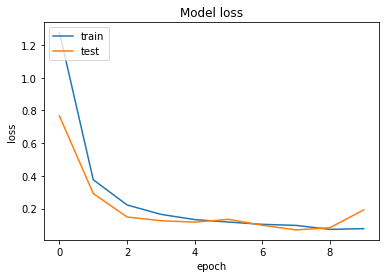

In [ ]:
plot_train_history(history_v2)

In [ ]:
print(history_v2.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
score = model_v2.evaluate(x_test_new, y_test_new, verbose=1)
print('Score: ', score)

y_pred = model_v2.predict(x_test_new, batch_size=batch_size, verbose=1)
score = log_loss(y_test_new, y_pred)
print('Score log loss:', score)

79/79 [==============================] - 1s 9ms/step - loss: 0.1166 - accuracy: 0.9796
Score:  [0.11664527654647827, 0.9796000123023987]
63/63 [==============================] - 1s 7ms/step
Score log loss: 0.11664526971780945


In [ ]:
model_v2.save("opt_vanilla_cnn_10epo.h5")

## Train a CNN with Transfer Learning (VGG, MobileNet)

In [ ]:
def vgg_std16_model(img_rows, img_cols, color_type=3):
    nb_classes = 10
    # Remove fully connected layer and replace
    # with softmax for classifying 10 classes
    vgg16_model = VGG16(weights="imagenet", include_top=False)

    # Freeze all layers of the pre-trained model
    for layer in vgg16_model.layers:
        layer.trainable = False

    x = vgg16_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(nb_classes, activation = 'softmax')(x)

    model = Model(inputs = vgg16_model.input, outputs = predictions)

    return model

In [ ]:
# Load the VGG16 network
print("Loading network...")
model_vgg16 = vgg_std16_model(img_rows, img_cols)

model_vgg16.summary()

model_vgg16.compile(loss='categorical_crossentropy',
                         optimizer='rmsprop',
                         metrics=['accuracy'])

Loading network...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, 

In [ ]:
# Prepare data augmentation configuration
train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1.0/ 255, validation_split = 0.2)

In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/Major Project/distracted_drivers_dataset/imgs/train/'
TEST_DIR = '/content/drive/MyDrive/Major Project/distracted_drivers_dataset/imgs/test/'

In [ ]:
training_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                 target_size = (img_rows, img_cols),
                                                 batch_size = batch_size,
                                                 shuffle=True,
                                                 class_mode='categorical', subset="training")

validation_generator = test_datagen.flow_from_directory(TRAIN_DIR,
                                                   target_size = (img_rows, img_cols),
                                                   batch_size = batch_size,
                                                   shuffle=False,
                                                   class_mode='categorical', subset="validation")
nb_train_samples = 15943
nb_validation_samples = 3981
print(validation_generator)

Found 15943 images belonging to 10 classes.
Found 3981 images belonging to 10 classes.


In [ ]:
# Training the Vanilla Model
checkpoint = ModelCheckpoint('saved_models/weights_best_vgg16.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history_v4 = model_vgg16.fit_generator(training_generator,
                         steps_per_epoch = 15943 // batch_size,
                         epochs = 5,
                         callbacks=[es, checkpoint],
                         verbose = 1,
                        #  class_weight='auto')
                         validation_data = validation_generator,
                         validation_steps = 3981 // batch_size)

Epoch 1/5
398/398 [==============================] - ETA: 0s - loss: 1.7081 - accuracy: 0.3964
Epoch 1: val_accuracy improved from -inf to 0.53207, saving model to saved_models/weights_best_vgg16.hdf5
398/398 [==============================] - 130s 319ms/step - loss: 1.7081 - accuracy: 0.3964 - val_loss: 1.2963 - val_accuracy: 0.5321
Epoch 2/5
398/398 [==============================] - ETA: 0s - loss: 1.2325 - accuracy: 0.5701
Epoch 2: val_accuracy improved from 0.53207 to 0.61869, saving model to saved_models/weights_best_vgg16.hdf5
398/398 [==============================] - 129s 324ms/step - loss: 1.2325 - accuracy: 0.5701 - val_loss: 1.0401 - val_accuracy: 0.6187
Epoch 3/5
398/398 [==============================] - ETA: 0s - loss: 1.0303 - accuracy: 0.6406
Epoch 3: val_accuracy improved from 0.61869 to 0.70025, saving model to saved_models/weights_best_vgg16.hdf5
398/398 [==============================] - 128s 321ms/step - loss: 1.0303 - accuracy: 0.6406 - val_loss: 0.8329 - val_acc

In [ ]:
model_vgg16.save("vgg16_epo10.h5")

**Testing and demo of the model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os

# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/MyDrive/"

# choose where you want your project files to be saved
project_folder = "Major Project"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  # !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)

FileNotFoundError: ignored

In [ ]:
!pwd

/content/drive/MyDrive/Major Project


In [ ]:
MODEL_PATH = '/content/drive/MyDrive/Major Project/opt_vanilla_cnn_30epo.h5'
TESTING_DATA_PATH = '/content/drive/MyDrive/Major Project/distracted_driver_dataset/imgs/test/'

In [ ]:
import tensorflow as tf
import os
from glob import glob
import random
import time
import tensorflow
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR messages are not printed

from tqdm import tqdm

import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
def get_cv2_image(path, img_rows, img_cols, color_type=3):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    # Reduce size
    img = cv2.resize(img, (img_rows, img_cols))
    return img

In [ ]:
# Testing
# In mounted Google drive
# /content/drive/MyDrive/Major Project/distracted_drivers_dataset/imgs/test/c0
def load_test_demo(img_rows, img_cols, color_type=3):
    # start_time = time.time()
    test_images = []
    test_labels = []
    # Loop over the testing folder
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('/content', 'drive', 'MyDrive', 'Major Project', 'distracted_drivers_dataset', 'imgs', 'test', 'c' + str(classed), '*.jpg'))
        i = 0
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            test_images.append(img)
            test_labels.append(classed)
            i=i+1
            if i==1:
              break
        # print(len(files),"**")
    # print("Data Loaded in {} second".format(time.time() - start_time))
    return test_images, test_labels


def read_and_normalize_test_data(img_rows, img_cols, color_type):
    X_test_new, labels = load_test_demo(img_rows, img_cols, color_type)
    y_test_new = np_utils.to_categorical(labels, 10)
    X_test_new = np.array(X_test_new, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    return X_test_new, y_test_new

In [ ]:
img_rows = 64
img_cols = 64
color_type = 1
NUMBER_CLASSES = 10

In [ ]:
x_test_new, y_test_new = read_and_normalize_test_data(img_rows, img_cols, color_type)
print('Test shape:', x_test_new.shape)
print(x_test_new.shape[0], 'test samples')

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:03<00:32,  3.59s/it]

Loading directory c1


 20%|██        | 2/10 [00:06<00:24,  3.11s/it]

Loading directory c2


 30%|███       | 3/10 [00:09<00:20,  2.91s/it]

Loading directory c3


 40%|████      | 4/10 [00:12<00:19,  3.22s/it]

Loading directory c4


 50%|█████     | 5/10 [00:15<00:14,  2.93s/it]

Loading directory c5


 60%|██████    | 6/10 [00:17<00:11,  2.75s/it]

Loading directory c6


 70%|███████   | 7/10 [00:20<00:08,  2.79s/it]

Loading directory c7


 80%|████████  | 8/10 [00:22<00:05,  2.71s/it]

Loading directory c8


 90%|█████████ | 9/10 [00:25<00:02,  2.78s/it]

Loading directory c9


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

Test shape: (10, 64, 64, 1)
10 test samples


In [ ]:
def load_test_img(img_rows, img_cols, color_type=3):
    # start_time = time.time()
    test_images = []
    test_labels = []
    # Loop over the testing folder
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('/content', 'drive', 'MyDrive', 'Major Project', 'distracted_drivers_dataset', 'imgs', 'test', 'c' + str(classed), '*.jpg'))
        i = 0
        for file in files:
            img = cv2.imread(file)
            test_images.append(img)
            i=i+1
            if i==1:
              break
        # print(len(files),"**")
    # print("Data Loaded in {} second".format(time.time() - start_time))
    return test_images

In [ ]:
from google.colab.patches import cv2_imshow
# test_imgs = load_test_demo(128,128,3)
# for i in test_imgs:
#   cv2_imshow(i)

In [ ]:
activity_map = {'c0': 'Safe driving',
                'c1': 'Texting on the phone - left',
                'c2': 'Talking on the phone - right',
                'c3': 'Texting on the phone - right',
                'c4': 'Talking on the phone - left',
                'c5': 'Operating the radio',
                'c6': 'Drinking',
                'c7': 'Reaching behind',
                'c8': 'Hair and makeup',
                'c9': 'Talking to passenger'}

Demo Image Paths:

1.   c0 - img_9605.jpg - Safe
2.   c5 - img_6689.jpg - Operating Radio
3. c6 - img_9263.jpg - Drinking
4. c8 - img_9459.jpg - Hair
5. c7 - img_5241.jpg - Reaching Behind



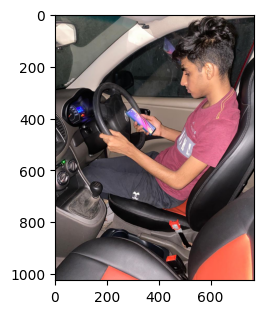

In [ ]:
plt.figure(figsize = (12, 20))
# image_count = 1
# BASE_PATH = '/content/drive/MyDrive/Major Project/distracted_drivers_dataset/imgs/test'
BASE_PATH = '/content/drive/MyDrive/Major Project/naitik_using_phone_new.jpeg'
directory = 'c7'
file_name = 'img_5241.jpg'
# IMG_PATH = BASE_PATH + '/' + directory + '/' + file_name
IMG_PATH = BASE_PATH
fig = plt.subplot(5, 2, 1)
# image_count += 1
image = mpimg.imread(IMG_PATH)
plt.imshow(image)
# plt.title(activity_map[directory])

In [ ]:
x_test_new = []
img_demo = get_cv2_image(IMG_PATH, 64, 64, 1)
x_test_new.append(img_demo)
x_test_new = np.array(x_test_new, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)

In [ ]:
model = tf.keras.models.load_model(MODEL_PATH)

In [ ]:
pred = model.predict(x_test_new)

print("Predicted Class:", activity_map['c' + str(np.argmax(pred))])

1/1 [==============================] - 0s 46ms/step
Predicted Class: Texting on the phone - right


In [ ]:
model_testing = create_model_v2()

# More details about the layers
model_testing.summary()

# Compiling the model
model_testing.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 62, 62, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                        